In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import os
import sys

import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt

from otf import optim
from otf import time_integration as ti
from otf.system import base as system_base

sys.path.append("..")
import error_surfaces as es

jndarray = jnp.ndarray
ndarray = np.ndarray

FIGURES_FOLDER = os.path.join(os.getcwd(), "figures", "partial-observations")
os.makedirs(FIGURES_FOLDER, exist_ok=True)

In [ ]:
def get_initial_values():
    # Initial true state
    u0 = jnp.array([0, 1, -1], dtype=float)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0


def true_ode(gs: jndarray, true: jndarray) -> jndarray:
    sigma, rho, beta = gs

    x, y, z = true

    return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])


def assimilated_ode(cs: jndarray, nudged: jndarray) -> jndarray:
    sigma, rho, beta = cs

    x, y, z = nudged

    return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])


true0, assimilated0 = get_initial_values()

# System evolution parameters
g1, g2, g3 = 10, 28, 8 / 3
gs = jnp.array([g1, g2, g3])
cs_center = gs.copy()

mu = 20
observed_slice = jnp.s_[:]

system = system_base.System_ModelKnown(
    mu, gs, None, observed_slice, assimilated_ode, true_ode
)

# Simulation parameters
dt = 0.01
T0, Tf = 0, 200
sim_Tf = 1200

solver = ti.ForwardEuler(system)
solver = ti.TwoStepAdamsBashforth(system, solver)

optimizer_kwargs = {"optimizer": optax.adam(1e-2)}
optimizer_type = optim.OptaxWrapper

true, _ = solver.solve_true(true0, T0, sim_Tf, dt)
true_observed = true[:, observed_slice]

In [ ]:
results = list()

n = 21
max_relative_step = 4

rng = np.random.default_rng(42)
start_relative_position = (2.2, -0.5)

for i, seed in enumerate((0, 1, 2, 42)):
    result = es.get_errors(
        system,
        true_observed,
        solver,
        dt,
        T0,
        Tf,
        assimilated0,
        cs_center,
        true_actual=true,
        seed=seed,
        xn=n,
        yn=n,
        x_relative_bound=max_relative_step,
        y_relative_bound=max_relative_step,
        start_relative_position=start_relative_position,
        optimizer_type=optimizer_type,
        optimizer_kwargs=optimizer_kwargs,
        sim_Tf=sim_Tf,
        sim_t_relax=1,
    )
    results.append(result)

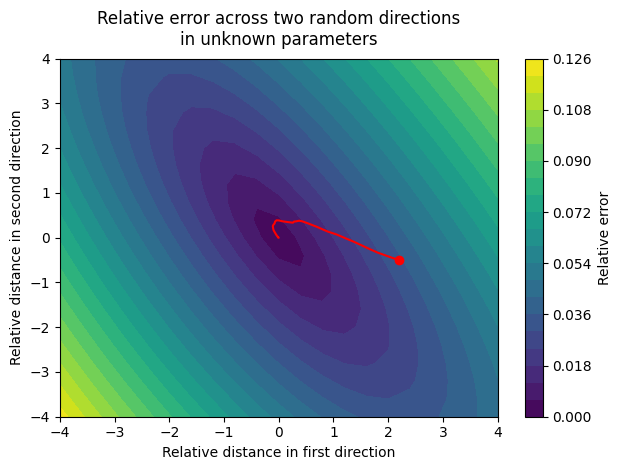

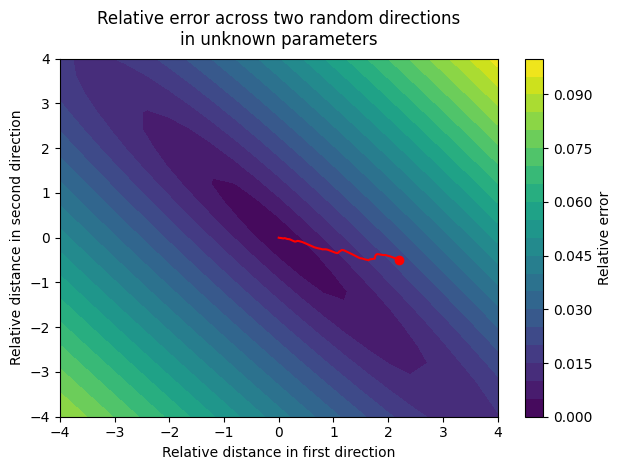

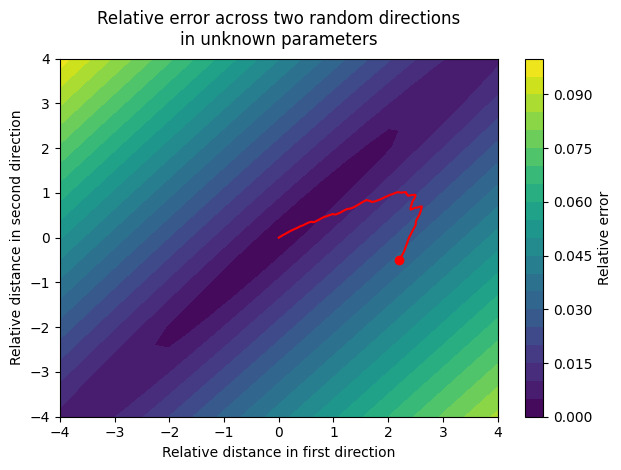

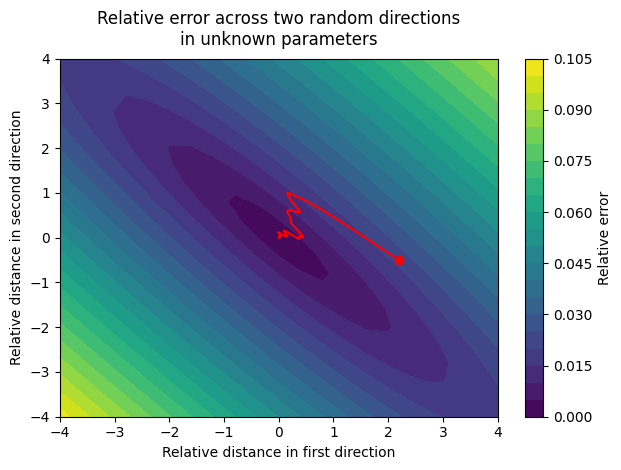

In [ ]:
for i, result in enumerate(results):
    errors = result["errors"]
    xls, yls = result["xls"], result["yls"]

    fig, ax = plt.subplots(1, 1)

    es.plot(fig, ax, errors, xls, yls)

    xs, ys = result["cs_coordinates"].T
    ax.plot(xs, ys, color="red")
    ax.scatter(xs[0], ys[0], color="red")

    ax.set_xlabel("Relative distance in first direction")
    ax.set_ylabel("Relative distance in second direction")
    ax.set_title(
        "Relative error across two random directions\nin unknown parameters",
        pad=10,
    )
    fig.tight_layout()
    fig.savefig(
        os.path.join(FIGURES_FOLDER, f"error-surface_{i:0>3}.svg"),
        format="svg",
    )